# download file from roboflow
roboflow could download our own uploaded dataset and it is very convinient and fast to download data from roboflow.

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AigV8d7mGnZ9MMZyXOX0")
project = rf.workspace().project("face-maks-yolo-v1")
dataset = project.version(2).download("voc")

ERROR: Operation cancelled by user
loading Roboflow workspace...
loading Roboflow project...


KeyboardInterrupt: ignored

file classification(image + annotation)

In [2]:
import os, shutil
def file_move(is_train = True):
  file_type = "train/"
  if not is_train:
    file_type = "valid/"
  main_dir = "/content/bigdog-1"
  file_path = os.path.join(main_dir, file_type)
  pathDir = os.listdir(file_path)
  target_images = os.path.join(file_path,"images/")
  target_annotations = os.path.join(file_path,"annotations/")
  if not os.path.exists(target_images):
    os.mkdir(target_images)
  if not os.path.exists(target_annotations):
    os.mkdir(target_annotations)
  for name in pathDir:
    if name[-1] == 'g':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_images)
    elif name[-1] == 'l':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_annotations)

file_move(is_train = False)
file_move()

# data preprocessing



In [1]:
DATA_PATH = "/content/bigdog-1/train/"
NUM_BBOX = 2
NUM_CLASS = 0

In [9]:
import xml.etree.ElementTree as ET
import os
import cv2

def convert_annotation(annotation_name):
  in_file = open(DATA_PATH + 'annotations/%s'%(annotation_name))
  image_id = annotation_name[0: len(annotation_name)-4]
  label_path = os.path.join(DATA_PATH, 'labels/')
  if not os.path.exists(label_path):
    os.mkdir(label_path)
  out_file = open(label_path+'%s.txt'%(image_id),'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)
  for obj in root.iter('object'):
    # cls = obj.find('name').text
    # if cls not in CLASSEs:
    #   continue
    # cls_id = CLASSES.index(cls)
    xmlbox = obj.find('bndbox')
    location = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
             float(xmlbox.find('ymax').text))
    bounding_box = convert((w,h),location)
    out_file.write(" ".join([str(a) for a in bounding_box])+"\n")

def xml2txt():
  dir = os.listdir(DATA_PATH+'annotations')
  for file in dir:
    convert_annotation(file)

def convert(size, box):
    # dw = 1. / size[0] #for normalization
    # dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    # x = x * dw
    # w = w * dw
    # y = y * dh
    # h = h * dh
    return (x, y, w, h)
xml2txt()

# face dataset
To prepare the dataset class for pytorch data loader

In [2]:
from torch.utils.data import Dataset
import torchvision
import numpy as np

class mask_data_set(Dataset):
    def __init__(self, is_train=True):
      self.filenames = []
      self.root_path = "/content/bigdog-1/train"
      if is_train:
        f = os.listdir("/content/bigdog-1/train/images")
        self.filenames = [x[0:len(x)-4] for x in f]
      else:
        f = os.listdir("/content/bigdog-1/valid/images")
        self.filenames = [x[0:len(x)-4] for x in f]
        self.root_path = "/content/bigdog-1/valid"
      self.img_path = os.path.join(self.root_path, "images/")
      self.label_path = os.path.join(self.root_path, "labels/")

    def __len__(self):
      return len(self.filenames)
  
    def __getitem__(self, item):
      img = cv2.imread(self.img_path+self.filenames[item]+'.jpg')
      img = cv2.resize(img,(448,448))
      f = open(self.label_path+self.filenames[item]+'.txt')
      bbox = f.read().split('\n')
      bbox = [x.split() for x in bbox]
      bbox = bbox[0:len(bbox)-1]
      labels = self.bbox2label(bbox)
      img = torchvision.transforms.ToTensor()(img)
      labels = torchvision.transforms.ToTensor()(labels)
      return img, labels


    def bbox2label(self, bbox):
      cell_size = 7
      img_size = 448
      output = np.zeros((cell_size,cell_size,5+NUM_CLASS))
      for box in bbox:
        x = float(box[0])
        y = float(box[1])
        w = float(box[2])
        h = float(box[3])
        x_cell = int(x * cell_size / img_size)
        y_cell = int(y * cell_size / img_size)
        result = [x,y,w,h,1]
        output[x_cell, y_cell] = result
      return output

# draw bounding box to test the result
to ensure the correctness of the data preprocessing result, drawing bounding box is a good way.

In [ ]:
jjdataset = mask_data_set(is_train=False)
img4, label4 = jjdataset.__getitem__(item=4)

In [ ]:
image4, label4 = jjdataset.__getitem__(4)

In [ ]:
image4 = image4.permute(1,2,0).float()
image4 = image4.numpy()

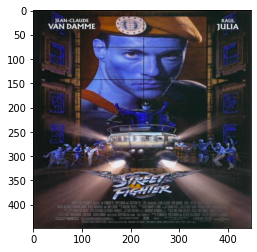

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image4)

## draw bounding box

In [3]:
import cv2
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  return img

In [ ]:
new_img = bounding_box_show(label4[:,3,3], image4)

In [ ]:
type(image4)

numpy.ndarray

In [ ]:
img = cv2.imread("/content/dogs!!!-1/train/images/n02085620_10074_jpg.rf.82277f35032f21145b22da6274e4fd68.jpg")

# LOSS function
the loss function of YOLO V1

In [21]:
import math
import torch
import torch.nn as nn

class yolov1_Loss(nn.Module):
  def __init__(self):
        super(yolov1_Loss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

  def calculate_IOU(self, box1,box2):
      left_x1 = box1[0]-box1[3]/2
      left_y1 = box1[1]+box1[2]/2
      right_x1 = box1[0]+box1[3]/2
      right_y1 = box1[1]-box1[2]/2
      rec1 = [left_x1, left_y1, right_x1, right_y1]
      left_x2 = box2[0]-box2[3]/2
      left_y2 = box2[1]+box2[2]/2
      right_x2 = box2[0]+box2[3]/2
      right_y2 = box2[1]-box2[2]/2
      rec2 = [left_x2, left_y2, right_x2, right_y2]
      left_max  = max(rec1[0],rec2[0])
      top_max = max(rec1[1],rec2[1])
      right_min = min(rec1[2],rec2[2])
      bottom_min = min(rec1[3],rec2[3])
      #if box1 and box2 are intersecting each other
      if (left_max < right_min or bottom_min > top_max):
        rect1_area = (rec1[2]-rec1[0])*(rec1[3]-rec1[1])
        rect2_area = (rec2[2]-rec2[0])*(rec2[3]-rec2[1])
        area_cross = (bottom_min - top_max)*(right_min - left_max)
        return area_cross/(rect1_area+rect2_area-area_cross)
      else:
        return 0


    # define the 5 components of the loss function(tested!!!!!!!!!)
  def center_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(box[0:2]), torch.flatten(gt_box[0:2]))
      return loss

  def wh_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(torch.sqrt(abs(box[2:4]))), torch.flatten(torch.sqrt(gt_box[2:4])))
      return loss

  def object_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(100).float().cuda())

  def noobject_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(0).float().cuda())

  def classification_loss(self, pred_class, gt_box):
      loss = self.mse(torch.flatten(pred_class), torch.flatten(gt_box[5:]))
      return loss

  # the whole process
  def forward(self, pred, labels):
        # five components of the loss function
        bnd_center_loss = 0  # bounding box center loss
        bnd_wh_loss = 0  # bounding box width and height loss
        obj_confident_loss = 0  # confidence loss for bounding box with object witin
        noobj_confident_loss = 0  # confidence loss for bounding box without object within
        # classification_loss = 0  # classification loss
        n_batch = labels.shape[0]
        for i in range(n_batch):
          for m in range(7):
            for n in range(7):
              #only iterate column with confidence value =1
              if labels[i, 4, m, n] == 1:
                # first we need to select the bounding box which has
                # a higher IOU with the ground truth bounding box
                current_pred = pred[i,:, m, n]
                current_label = labels[i,:, m, n]
                box1 = current_pred[0:5]
                pred_class = current_pred[10:]
                box2 = current_pred[5:10]
                iou1 = self.calculate_IOU(box1, current_label)
                iou2 = self.calculate_IOU(box2, current_label)
                # print('box1:  {}\n, box2: {}'.format(iou1,iou2))
                #if box1 has a higher iou, then box1 would be responsible for this task.
                if iou1 >= iou2:
                  bnd_center_loss += self.center_loss(box1, current_label)                     
                  bnd_wh_loss += self.wh_loss(box1, current_label)
                  obj_confident_loss += self.object_confidence_loss(box1, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box2, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
                # otherwise, box2 would take this responsibility!
                else:
                  bnd_center_loss += self.center_loss(box2, current_label)                     
                  bnd_wh_loss += self.wh_loss(box2, current_label)
                  obj_confident_loss += self.object_confidence_loss(box2, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box1, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
              else:
                noobj_confident_loss += torch.sum(pred[i,[4,9],m,n]**2)
        print("current_pred:  ", current_pred)
        print("current_label: ", current_label)
        total_loss = bnd_center_loss + bnd_wh_loss + obj_confident_loss + noobj_confident_loss
        return torch.sum(total_loss)/n_batch

# Test loss function
The loss function is combined with 5 parts including the iou calculation.
To ensure the accuracy, I test all of them there.

test calculate_IOU

In [ ]:
mse = nn.MSELoss(reduction="sum")

In [ ]:
def calculate_IOU(box1,box2):
    left_x1 = box1[0]-box1[3]/2
    left_y1 = box1[1]+box1[2]/2
    right_x1 = box1[0]+box1[3]/2
    right_y1 = box1[1]-box1[2]/2
    rec1 = [left_x1, left_y1, right_x1, right_y1]
    #box2
    left_x2 = box2[0]-box2[3]/2
    left_y2 = box2[1]+box2[2]/2
    right_x2 = box2[0]+box2[3]/2
    right_y2 = box2[1]-box2[2]/2
    rec2 = [left_x2, left_y2, right_x2, right_y2]
    left_max  = max(rec1[0],rec2[0])
    top_max = max(rec1[1],rec2[1])
    right_min = min(rec1[2],rec2[2])
    bottom_min = min(rec1[3],rec2[3])
    #if box1 and box2 are intersecting each other
    if (left_max < right_min or bottom_min > top_max):
      rect1_area = (rec1[2]-rec1[0])*(rec1[3]-rec1[1])
      rect2_area = (rec2[2]-rec2[0])*(rec2[3]-rec2[1])
      area_cross = (bottom_min - top_max)*(right_min - left_max)
      return area_cross/(rect1_area+rect2_area-area_cross)
    else:
      return 0

In [ ]:
#     x  y  h  w
box1 = torch.tensor([68, 82, 52, 45,  1,  1,  0,  0], dtype = float)
box2 = torch.tensor([53, 75, 52, 56,  1,  0,  1,  0], dtype = float)
calculate_IOU(box1, box2)
mse(torch.flatten(torch.sqrt(abs(box1[5:]))), torch.flatten(torch.sqrt(box2[5:])))

tensor(2., dtype=torch.float64)

test center_loss

In [ ]:
def center_loss(box, gt_box):
  # box size: [confidence, cx, cy, w, h]
  loss = 5 * mse(torch.flatten(box1[1:3]), torch.flatten(box2[1:3]))
  return loss
center_loss(box1, box2)

tensor(245., dtype=torch.float64)

test wh_loss

In [ ]:
def wh_loss(box, gt_box):
  # box size: [confidence, cx, cy, w, h]
  loss = 5 * mse(torch.flatten(torch.sqrt(abs(box1[3:4]))), torch.flatten(torch.sqrt(box2[3:4])))
  return loss
wh_loss(box1, box2)

tensor(3.0040, dtype=torch.float64)

test object_confidence_loss

In [ ]:
def object_confidence_loss(box, box2):
  return box[4]-box2[4]
object_confidence_loss(box1, box2)

tensor(0., dtype=torch.float64)

test classification_loss

In [ ]:
def classification_loss(pred_class, gt_box):
  loss = mse(torch.flatten(box1[5:]), torch.flatten(box2[5:]))
  return loss
classification_loss(box1, box2)

tensor(2., dtype=torch.float64)

# Model
The original yolo v1 model


In [4]:
import torch
import torch.nn as nn

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

target_image_size = 448


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1)).reshape(-1, 10, 7, 7)

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

x = torch.randn((5,3,448,448))
net = Yolov1(split_size=7, num_boxes=2, num_classes=0)
print(net)
y = net(x)
print(y.shape)

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

# training

In [8]:
import torch
from torch.utils.data import DataLoader
import cv2

In [6]:
import os
epoch = 60
batchsize = 32
dataset = mask_data_set(is_train=True)
train_dataloader = DataLoader(dataset, batchsize, shuffle = True)

In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=0).cuda()
criterion = yolov1_Loss()
training_loss = np.zeros(epoch)
saved_model_path = "/content/saved_models"
if not os.path.exists(saved_model_path):
  os.mkdir("/content/saved_models")
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)
for e in range(epoch):
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.float().cuda()
        labels = labels.float().cuda()
        pred = model(inputs)
        # print(pred.shape, labels.shape)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("----------------------------------------------------------------------------------------------")
        print("Epoch %d/%d| Step %d/%d| Loss: %.2f" % (e+1, epoch, i, len(dataset) // batchsize, loss))
        print("----------------------------------------------------------------------------------------------")
    training_loss[e] = loss
    if (e + 1) % 20 == 0:
      torch.save(model, "./saved_models/YOLOv1_epoch" + str(e + 1) + ".pkl")

## the training error in different epochs.

Text(0, 0.5, 'error')

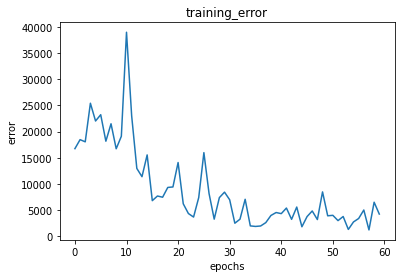

In [13]:
import matplotlib.pyplot as plt
x = range(0,60)
plt.plot(x, training_loss)
plt.title("training_error")
plt.xlabel("epochs")
plt.ylabel("error")

# evaluation

In [14]:
import torch
from torch.utils.data import DataLoader

In [15]:
batchsize = 1
dataset = mask_data_set(is_train=False)
val_dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [28]:
model = torch.load("/content/saved_models/YOLOv1_epoch60.pkl")

from the evaluation, we can see the loss is obviously higher than training loss, which means it endures overfitting. However, we can see for each bounding box the model predited, the class is correctly predicted and the coordinates predicted are very similar to the ground truth coordinates, which is not bad.

In [25]:
criterion = yolov1_Loss()

In [24]:
loss = np.zeros(dataset.__len__())

In [29]:
for i, (inputs, labels) in enumerate(val_dataloader):
  inputs = inputs.float().cuda()
  labels = labels.float().cuda()
  pred = model(inputs)
  l = criterion(pred, labels)
  loss[i] = l

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


current_pred:   tensor([ 2.0837e+02,  1.2740e+02, -2.3057e+02,  1.7786e+02,  1.4271e-01,
         2.1748e+02,  1.0784e+02,  9.1526e+01,  1.0684e+02,  1.0874e+02],
       device='cuda:0', grad_fn=<SelectBackward0>)
current_label:  tensor([213.5000,  98.5000, 107.0000, 125.0000,   1.0000], device='cuda:0')
current_pred:   tensor([ 233.3297,  127.5320,  159.2483,  182.9608,    6.2893,  233.9528,
         160.1211, -173.7406,  196.9354,   -1.0422], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([236., 128., 176., 254.,   1.], device='cuda:0')
current_pred:   tensor([ 2.0650e+02,  1.2607e+02, -2.2740e+02,  1.7520e+02,  2.0029e-01,
         2.1214e+02,  1.0406e+02,  8.9697e+01,  1.0345e+02,  1.0869e+02],
       device='cuda:0', grad_fn=<SelectBackward0>)
current_label:  tensor([205.5000,  98.5000,  47.0000,  79.0000,   1.0000], device='cuda:0')
current_pred:   tensor([ 227.9583,  242.1302,  169.1168,  232.4271,   99.4785,  222.9796,
         217.3134, -214.7829,  2

we can see the model trained for 60 epochs has average training error of almost 10000 and average evaluation error of 11269. Therefore, this model didnt endure overfitting.

In [30]:
loss.sum()/dataset.__len__()

13595.505199517143

# Prediction
{'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3, }


In [31]:
import cv2
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  return img

def max_index(t):
  for index, i in enumerate(t):
    if i == max(t):
      return index
  return -1

def classification(pred):
  mask = []
  face = []
  incorrect = []
  for i in range(7):
    for j in range(7):
      onehot = pred[i,j,10:13]
      pred_class = max_index(onehot)
      if pred_class == 0:
        mask.append(pred[i,j])
      elif pred_class == 1:
        face.append(pred[i,j])
      else:
        incorrect.append(pred[i,j])
  mask = move_the_bad(mask)
  face = move_the_bad(face)
  incorrect = move_the_bad(incorrect)
  return mask, face, incorrect

def move_the_bad(boxes):
  for index, box in enumerate(boxes):
    if box[4]>=box[9]:
      box = torch.cat((box[0:5],box[10:13]),dim=0)
    else:
      box = torch.cat((box[5:10],box[10:13]),dim=0)
    boxes[index] = box
  return boxes

def NMS(boxes):
  maximum = 0
  best_box = None
  for index,box in enumerate(boxes):
    if box[4]>maximum:
      maximum = box[4]
      best_box = box
  return boxes


def predict(img):
  pred = model(img)
  pred = pred.squeeze(dim=0)
  pred = pred.permute((1,2,0))
  mask, face, incorrect = classification(pred)
  mask = NMS(mask)
  face = NMS(face)
  incorrect = NMS(incorrect)
  return mask, face, incorrect

img3, label3 = dataset.__getitem__(3)
img3 = img3.resize(1,img3.shape[0],img3.shape[1],img3.shape[2]).float().cuda()
mask, face, incorrect = predict(img3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


only face

In [35]:
import cv2
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  return img

def processing(pred):
  face = []
  for i in range(7):
    for j in range(7):
      face.append(pred[i,j])
  face = NMS(move_the_bad(face))
  return face

def move_the_bad(boxes):
  for index, box in enumerate(boxes):
    if box[4]>box[9]:
      box = box[0:5]
    else:
      box = box[5:10]
    boxes[index] = box
  return boxes

def NMS(boxes):
  maximum = 0
  best_box = None
  for index,box in enumerate(boxes):
    if box[4]>maximum:
      maximum = box[4]
      best_box = box
  return best_box


def predict(img):
  pred = model(img)
  pred = pred.squeeze(dim=0)
  pred = pred.permute((1,2,0))
  face = processing(pred)
  return face

img3, label3 = dataset.__getitem__(9)
img3 = img3.resize(1,img3.shape[0],img3.shape[1],img3.shape[2]).float().cuda()
result = predict(img3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [60]:
result

tensor([ 71.8343, -33.4635, -18.1172,  30.1056,   3.6405], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [71]:
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  img = cv2.putText(img,'face',(right[0],right[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  return img

In [78]:
im1 = plt.imread('/content/WIN_20211128_07_41_53_Pro.jpg')
im1 = cv2.resize(im1, (448,448))
tensor_im1 =torchvision.transforms.ToTensor()(im1)
tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
result = predict(tensor_im1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [79]:
new_img = bounding_box_show(result, im1)

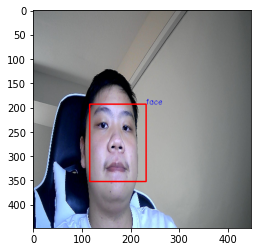

In [80]:
plt.imshow(im1)